In [1]:
# import dependencies
# !pip uninstall umap --yes
# !pip install umap-learn
# !pip install cuml

# !pip install numba

import pandas as pd
import json
import xgboost
import lightgbm
import gc

# import umap

import umap.umap_ as umap

pd.options.mode.chained_assignment = None  # default='warn'

numeraiDir = '.'
import numeraiutils as num





/home/mathiasvanaelten/miniconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
target='target'
keys = ['era', 'data_type', target]

# In[ load data ]
print('Loading data')

f = open('features.json')
j = json.load(f)

train = pd.read_parquet('numerai_training_data_int8.parquet')
val = pd.read_parquet('numerai_validation_data_int8.parquet')
td = pd.read_parquet('numerai_tournament_data_int8.parquet')

# new_train = pd.read_csv('new_train_umap_1205.csv')


train_small = train.sample(n=100000)


Loading data


In [3]:
# all features
# features = [c for c in train if c.startswith("feature")]

# selected features for speed
features = j['feature_sets']['medium'] # small / medium / legacy

targets = [c for c in train if c.startswith("target")]

train = train_small[keys + features]
val = val[keys + features]
td = td[keys + features]



/home/mathiasvanaelten/miniconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/mathiasvanaelten/miniconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Numerai score (spearman correlation): nan, STD: nan
Sharpe ratio: nan
Sortino ratio: 0.0000
Max drawdown: nan
Max feature exposure:  0.35031554806057164



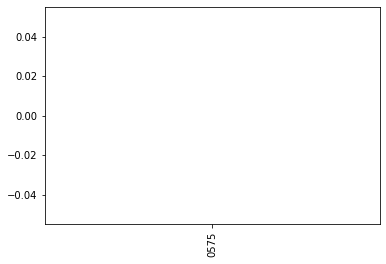

In [5]:
# In[ baseline model ]

xgb_params = {
    "n_estimators" : 1000,
    "max_depth" : 5,
    "learning_rate" : 0.01,
    "colsample_bytree" : 0.1,
#     "tree_method" : 'gpu_hist'
    }
    
est = xgboost.XGBRegressor(**xgb_params)


#validation
# est.fit(train[features], train[target])
# val['pred'] = est.predict(val[features])

# num.evaluation(val, features)
# val = val.rename(columns={'pred':'prediction'})
# val['prediction'].to_csv('validation_baseline.csv')


# tournament
est.fit(train[features], train[target])
td['pred'] = est.predict(td[features])

num.evaluation(td, features)
td = td.rename(columns={'pred':'prediction'})
td['prediction'].to_csv('tournament_baseline.csv')


In [6]:
# Numerai score (spearman correlation): 0.0208, STD: 0.0329
# Sharpe ratio: 0.6320
# Sortino ratio: 1.6578
# Max drawdown: -0.19033823759034238
# Max feature exposure:  0.4509352785060702

# In[ fit umap model with full dataset that includes validation and tournament data]

n_neighbors = 15
min_dist = 0
n_components = 60

train_full = pd.concat([train, val, td[::10]]).reset_index()
train_tr = pd.concat([train, val]).reset_index()


umap = umap.UMAP(n_neighbors = n_neighbors, min_dist=min_dist, n_components=n_components, random_state=42)
data = umap.fit_transform(train_full[features])
# data = umap.
umap_features = [f'f_{i}' for i in range(data.shape[1])]

pData = pd.DataFrame(data, columns=umap_features).iloc[:len(train_tr)]
new_train = pd.concat([train_tr, pData], axis=1)    
new_features = features + umap_features

new_features_umap = open("new_features.txt", "w")
for element in new_features:
    new_features_umap.write(element + "\n")
new_features_umap.close()


new_train.to_csv('new_train_1705.csv')

# del train_full
# del train_tr
del umap
# del data
# del pData

gc.collect()




/home/mathiasvanaelten/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


28374

In [19]:
new_features_umap = open("new_features.txt", "w")
for element in new_features:
    new_features_umap.write(element + "\n")
new_features_umap.close()

In [10]:
umap_features.info

AttributeError: 'list' object has no attribute 'info'

In [25]:
new_train.head()

,id,era,data_type,target,feature_abstersive_emotional_misinterpreter,feature_accessorial_aroused_crochet,feature_acerb_venusian_piety,feature_affricative_bromic_raftsman,feature_agile_unrespited_gaucho,feature_agronomic_cryptal_advisor,...,f_51,f_52,f_53,f_54,f_55,f_56,f_57,f_58,f_59,pred
0,n321d3ae0ae1f8d1,0268,train,0.75,0,1,2,2,1,1,...,3.990151,1.222788,0.992212,0.253165,1.477129,0.337896,3.005283,1.157143,0.571911,-1.115865e+30
1,nd56ed35aff8a880,0312,train,0.50,4,3,4,4,3,0,...,4.004501,0.504751,0.460815,0.292481,1.266612,0.527511,2.541840,1.630240,1.781809,-1.115865e+30
2,nbd9212e79d69e9b,0113,train,0.50,0,0,4,4,2,3,...,4.014765,0.642362,0.533603,0.292779,1.369430,0.473182,2.714279,1.529756,1.319361,-1.115865e+30
3,ne900f90134d6d6c,0488,train,0.50,4,1,4,3,0,0,...,4.044486,0.401176,0.483460,0.169831,1.292827,0.304835,2.593655,1.656713,2.001607,-1.115865e+30
4,n849aee664f16de2,0146,train,0.25,3,4,3,3,1,4,...,4.293693,1.121301,1.271419,0.076249,1.636805,0.972486,2.268829,0.597005,0.087508,-1.115865e+30


In [34]:
new_train.set_axis([new_features], axis='0')

IndexError: index 61 is out of bounds for axis 0 with size 61

/home/mathiasvanaelten/miniconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/mathiasvanaelten/miniconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Numerai score (spearman correlation): 0.0095, STD: 0.0190
Sharpe ratio: 0.5005
Sortino ratio: 1.0864
Max drawdown: -0.13217551332165225
Max feature exposure:  0.21600216697096575



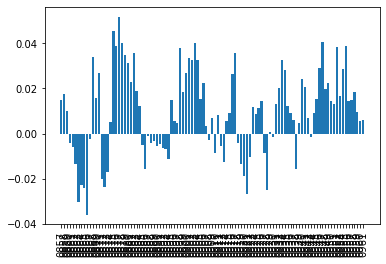

In [7]:
# In[ retrain estimator on the complete extended dataset ]

est = xgboost.XGBRegressor(**xgb_params)

est.fit(new_train.loc[new_train.data_type=='train', new_features], new_train.loc[new_train.data_type=='train', target])
new_train.loc[new_train.data_type=='validation', 'pred'] = est.predict(new_train.loc[new_train.data_type=='validation', new_features])
num.evaluation(new_train[new_train.data_type=='validation'], new_features)


val['prediction'] = new_train.loc[new_train.data_type=='validation', 'pred'].values
val['prediction'].to_csv('validation_allFeatures_1705.csv')




# est.save_model("xgb_umap_1605.txt")

# td['prediction'] = est.predict(td[features])

# est = xgboost.Booster()
# est.load_model("xgb_umap_1605.txt")

# new_train.loc[new_train.data_type=='validation', 'pred'] = est.predict(new_train.loc[new_train.data_type=='validation', new_features])
# num.evaluation(new_train[new_train.data_type=='tournament'], new_features)

# td['prediction'] = est.predict(td[new_features])

# # Format prediction CSV for submission
# prediction_df = td.reset_index()[['id', 'prediction']]
# prediction_df[['id', 'prediction']].to_csv('Tournament_UMAP_1605_predictions.csv', index=False) # Important to name your CSV file so you know wh

# # td['prediction'] = new_train.loc[new_train.data_type=='tournament', 'pred'].values
# # td['prediction'].to_csv('validation_allFeatures_1605.csv')



# Numerai score (spearman correlation): 0.0213, STD: 0.0329
# Sharpe ratio: 0.6495
# Sortino ratio: 1.7063
# Max drawdown: -0.20478065308905238
# Max feature exposure:  0.4371256652128962




/home/mathiasvanaelten/miniconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/mathiasvanaelten/miniconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Numerai score (spearman correlation): 0.0045, STD: 0.0124
Sharpe ratio: 0.3629
Sortino ratio: 0.7582
Max drawdown: -0.09638373476700227
Max feature exposure:  0.062120378332842605



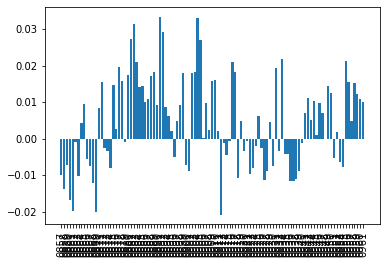

In [8]:
# In[ retrain estimator on the extended dataset only ]

est = xgboost.XGBRegressor(**xgb_params)
est.fit(new_train.loc[new_train.data_type=='train', umap_features], new_train.loc[new_train.data_type=='train', target])
new_train.loc[new_train.data_type=='validation', 'pred'] = est.predict(new_train.loc[new_train.data_type=='validation', umap_features])
num.evaluation(new_train[new_train.data_type=='validation'], features)

val['prediction'] = new_train.loc[new_train.data_type=='validation', 'pred'].values
val['prediction'].to_csv('validation_umapFeatures.csv')

# Numerai score (spearman correlation): 0.0073, STD: 0.0158
# Sharpe ratio: 0.4651
# Sortino ratio: 0.9302
# Max drawdown: -0.10544801045624015
# Max feature exposure:  0.07221613666926133


In [ ]:
# Instantiate Numerai API again but with API keys for submission
PUBLIC_KEY = ''
PRIVATE_KEY = ''

napi = numerapi.NumerAPI(PUBLIC_KEY, PRIVATE_KEY)
current_round = napi.get_current_round()
print("ROUND NUMBER: ", current_round)

In [ ]:
# Format prediction CSV for submission
prediction_df = td.reset_index()[['id', 'prediction']]
prediction_df[['id', 'prediction']].to_csv(f'round{current_round}_UMAP_XGB_predictions.csv', index=False) # Important to name your CSV file so you know wh

In [ ]:
# # MAT_BRAIN_DF2
model_id = ''


napi.upload_predictions(f'round{current_round}_UMAP_XGB_predictions.csv', model_id=model_id, version=2)